In [1]:
!pip install torch_geometric
!pip install rdkit
!pip install umap-learn
!pip install hdbscan
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 36.1 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import WeightedRandomSampler

from data_loaders import preproccess_data, generate_scaffold_split, df_to_graph_list, get_scaffolds
from gcn import GCN
from train_utils import plot_losses, train, evaluate_model

from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats

import toml

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# apply weighted calc to the train set (which is 1/freq) to handle scaffold imbalance
def calc_weight(scaffold_val):
    return 1.0 / scaffold_counts[scaffold_val]

# need this in scope for the next code block

In [7]:
file_path = '/content/drive/MyDrive/BioSolveAI/data/curated-solubility-dataset.csv'
df = preproccess_data(file_path)


df['scaffold'] = df['mol'].apply(get_scaffolds)

# scaffolds to get train, val, text
train_idx, val_idx, test_idx = generate_scaffold_split(df)

# Split the dataframe into train, val, and test
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

# sscaffold frequency weighting
scaffold_counts = train_df['scaffold'].value_counts()
train_df['sample_weight'] = train_df['scaffold'].apply(calc_weight)

# create the WeightedRandomSampler using these sample weights
weights = torch.tensor(train_df['sample_weight'].tolist(), dtype=torch.float)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# df to graph list
train_graph_list = df_to_graph_list(train_df)
val_graph_list = df_to_graph_list(val_df)
test_graph_list = df_to_graph_list(test_df)

<ipython-input-7-9cf783dbf101>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sample_weight'] = train_df['scaffold'].apply(calc_weight)


In [8]:
config = toml.load("config.toml")

# access the parameters
batch_size = config["BATCH_SIZE"]
epochs = config["EPOCHS"]
learning_rate = config["LEARNING_RATE"]
weight_decay = config["WEIGHT_DECAY"]

print("Batch size:", batch_size)
print("Epochs:", epochs)
print("Learning rate:", learning_rate)
print("Weight decay:", weight_decay)

Batch size: 32
Epochs: 60
Learning rate: 0.0008935532131641973
Weight decay: 0.006955968863499973


In [9]:
train_loader = DataLoader(train_graph_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graph_list, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graph_list, batch_size=batch_size, shuffle=False)

Epoch: 1, Train Loss: 1.1001, Val Loss: 0.4427
Epoch: 2, Train Loss: 0.6560, Val Loss: 0.3875
Epoch: 3, Train Loss: 0.5644, Val Loss: 0.4021
Epoch: 4, Train Loss: 0.5326, Val Loss: 0.3543
Epoch: 5, Train Loss: 0.5078, Val Loss: 0.3243
Epoch: 6, Train Loss: 0.4834, Val Loss: 0.2990
Epoch: 7, Train Loss: 0.4663, Val Loss: 0.2798
Epoch: 8, Train Loss: 0.4623, Val Loss: 0.2935
Epoch: 9, Train Loss: 0.4337, Val Loss: 0.3258
Epoch: 10, Train Loss: 0.4228, Val Loss: 0.2766
Epoch: 11, Train Loss: 0.4123, Val Loss: 0.2562
Epoch: 12, Train Loss: 0.4022, Val Loss: 0.2528
Epoch: 13, Train Loss: 0.3889, Val Loss: 0.2664
Epoch: 14, Train Loss: 0.3867, Val Loss: 0.2744
Epoch: 15, Train Loss: 0.3750, Val Loss: 0.2567
Epoch: 16, Train Loss: 0.3716, Val Loss: 0.2646
Epoch: 17, Train Loss: 0.3682, Val Loss: 0.2488
Epoch: 18, Train Loss: 0.3599, Val Loss: 0.2510
Epoch: 19, Train Loss: 0.3596, Val Loss: 0.2463
Epoch: 20, Train Loss: 0.3505, Val Loss: 0.2499
Epoch: 21, Train Loss: 0.3567, Val Loss: 0.2587
E

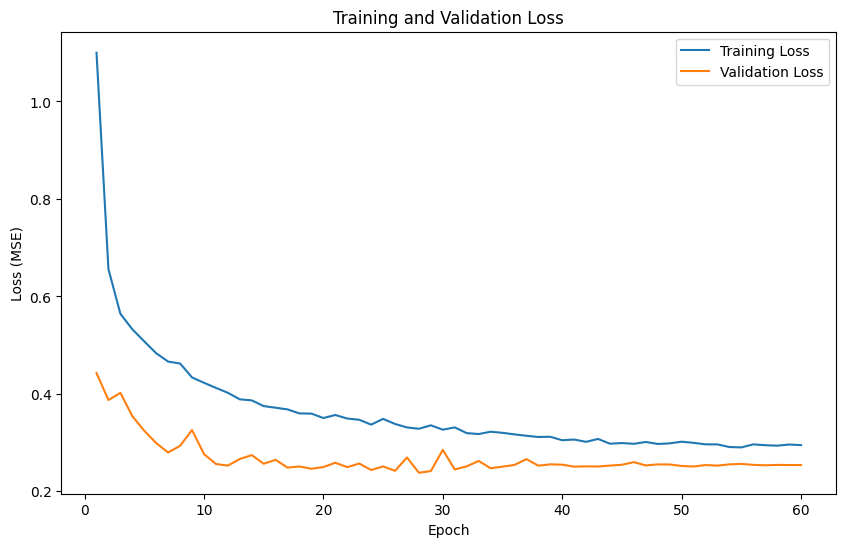

In [10]:
num_node_dim = train_graph_list[0].x.shape[1]
edge_attr_dim = train_graph_list[0].edge_attr.shape[1]
u_dim = train_graph_list[0].u.shape[1]

# init model
model = GCN(num_node_features=num_node_dim,
            edge_attr_dim=edge_attr_dim,
            u_dim=u_dim,
            hidden_dim=64,
            output_dim=1).to(device)

train(model, train_loader, val_loader, epochs, learning_rate, weight_decay, device);


In [14]:
evaluate_model(model, test_loader, device);

Test RMSE: 0.4362 with 95% CI: [0.4103, 0.4606]
Test R²: 0.7144 with 95% CI: [0.6743, 0.7509]
